In [34]:
#|hide
#|default_exp data

# Data level

Reading and advance in data processing levels to be stored in netcdf database format.

```{note}
raw > l1a > l1b > l1c
```

In [35]:
#|export
import os
import numpy as np
import pandas as pd
import xarray as xr
import logging
from toolz import assoc_in
import pkg_resources as pkg_res
import warnings

from trosat import sunpos as sp

import pyrnet as pyrnet_main
pyrnet_version = pyrnet_main.__version__
from pyrnet import pyrnet
from pyrnet import utils as pyrutils
from pyrnet import logger as pyrlogger
from pyrnet import reports as pyrreports

# logging setup
logging.basicConfig(
    filename='pyrnet.log',
    encoding='utf-8',
    level=logging.DEBUG,
    format='%(asctime)s %(name)s %(levelname)s:%(message)s'
)
logger = logging.getLogger(__name__)

In [36]:
import matplotlib.pyplot as plt

## netCDF dataset operations


In [37]:
#|export
def update_coverage_meta(ds,timevar='time'):
    """Update global attributes related to geospatial and time coverage
    """
    duration = ds[timevar].values[-1] - ds[timevar].values[0]
    resolution = np.mean(np.diff(ds[timevar].values))
    now = pd.to_datetime(np.datetime64("now"))
    gattrs = {
        'date_created': now.isoformat(),
        'geospatial_lat_min': np.nanmin(ds.lat.values),
        'geospatial_lat_max': np.nanmax(ds.lat.values),
        'geospatial_lat_units': 'degN',
        'geospatial_lon_min': np.nanmin(ds.lon.values),
        'geospatial_lon_max': np.nanmax(ds.lon.values),
        'geospatial_lon_units': 'degE',
        'time_coverage_start': pd.to_datetime(ds[timevar].values[0]).isoformat(),
        'time_coverage_end': pd.to_datetime(ds[timevar].values[-1]).isoformat(),
        'time_coverage_duration': pd.to_timedelta(duration).isoformat(),
        'time_coverage_resolution': pd.to_timedelta(resolution).isoformat(),
    }
    ds.attrs.update(gattrs)
    return ds


In [68]:
#|export
def stretch_resolution(ds: xr.Dataset) -> xr.Dataset:
    """ Stretch variable resolution to full integer size,
    to not lose resolution after averaging ADC count data."""
    for var in ds:
        dtype = ds[var].encoding['dtype']
        valid_range = ds[var].valid_range
        int_limit = np.iinfo(dtype).max
        scale_factor = ds[var].encoding['scale_factor']
        scale_factor_mod = int((int_limit-1)/valid_range[1])
        ds[var].encoding.update({
            "scale_factor": scale_factor / scale_factor_mod,
            "_FillValue": int_limit,
            "valid_range": valid_range * scale_factor_mod
        })
    return ds

In [39]:
# ds_l1b.ghi.valid_range

In [40]:
#|export
def merge_ds(ds1,ds2):
    """Merge two datasets along the time dimension.
    """
    if ds1.time.equals(ds2.time):
        logging.info("Overwrite existing file.")
        return ds2
    logging.info("Merge with existing file.")

    ## overwrite non time dependent variables
    overwrite_vars = [ v for v in ds1 if "time" not in ds1[v].dims]

    ## merge both datasets
    ds_new=ds1.merge(ds2,compat='no_conflicts',overwrite_vars=overwrite_vars)

    # add global coverage attributes
    ds_new.attrs.update({'merged':1})
    return ds_new

In [41]:
#|export
def to_netcdf(ds,fname):
    """xarray to netcdf, but merge if exist
    """
    # merge if necessary
    if os.path.exists(fname):
        ds1 = xr.open_dataset(fname)
        ds = merge_ds(ds1,ds)
        os.remove(fname)

    # save to netCDF4
    ds = update_coverage_meta(ds, timevar="time")
    ds.to_netcdf(fname,
                 encoding={'time':{'dtype':'float64'}}) # for OpenDAP 2 compatibility

## Default config and nc encoding
Parse default config and cfmeta, and merge with user condfig

In [42]:
#|export
def get_config(config: dict|None = None) -> dict:
    """Read default config and merge with input config
    """

    fn_config = pkg_res.resource_filename("pyrnet", "share/pyrnet_config.json")
    default_config = pyrutils.read_json(fn_config)
    if config is None:
        config = default_config
    config = {**default_config, **config}

    # add default files
    cfiles = {
        "file_cfmeta": "share/pyrnet_cfmeta.json",
        "file_calibration": "share/pyrnet_calibration.json",
        "file_mapping": "share/pyrnet_station_map.json",
        "file_gti_angles": "share/pyrnet_gti_angles.json",
        "file_site": "share/pyrnet_sites.json",
    }
    for fn in cfiles:
        if config[fn] is None:
            config[fn] =  pkg_res.resource_filename("pyrnet", cfiles[fn])
    return config

def get_cfmeta(config: dict|None = None) -> dict:
    """Read global and variable attributes and encoding from cfmeta.json
    """
    config= get_config(config)
    # parse the json file
    cfdict = pyrutils.read_json(config["file_cfmeta"])
    # get global attributes:
    gattrs = cfdict['attributes']
    # apply config
    gattrs = {k:v.format_map(config) for k,v in gattrs.items()}
    # get variable attributes
    d = pyrutils.get_var_attrs(cfdict)
    # split encoding attributes
    vattrs, vencode = pyrutils.get_attrs_enc(d)
    return gattrs ,vattrs, vencode


## Encoding
The encoding attributes are defined within the file PyrNet/share/pyrnet_cfmeta.json per default.

The netcdf packing of data is realized via the two attributes *scale_factor* and *add_offset*:
  ```unpacked_variable = scale_factor * packed_variable + add_offset```

In [43]:
#|dropcode
#|dropout
fn_cfjson = pkg_res.resource_filename("pyrnet", "share/pyrnet_cfmeta.json")
pyrutils.read_json(fn_cfjson)

{'attributes': {'title': 'TROPOS pyranometer network (PyrNet) observations',
  'institution': 'Leibniz Institute for Tropospheric Research (TROPOS)',
  'department': 'Remote Sensing of Atmospheric Processes',
  'department_team': 'Clouds, Aerosol and Radiation',
  'address': 'Permoser Str. 15, 04318 Leipzig, Germany',
  'source': 'TROPOS pyranometer network (PyrNet)',
  'contact_person': 'Andreas Macke and the clouds, aerosol and radiation team of the remote sensing department, mailto:andreas.macke@tropos.de',
  'contributor_name': '{contributor_name}',
  'contributor_role': '{contributor_role}',
  'authors_software': 'Hartwig Deneke, Jonas Witthuhn, mailto:deneke@tropos.de',
  'creator_name': '{creator_name}',
  'project': '{project}',
  'references': 'https://doi.org/10.5194/amt-9-1153-2016',
  'standard_name_vocabulary': 'CF Standard Name Table v81',
  'conventions': 'CF-1.10, ACDD-1.3',
  'license': 'CC-BY-SA 3.0'},
 'variables': {'ta': {'type': 'u2',
   'attributes': {'units': 'K'

{'attributes': {'title': 'TROPOS pyranometer network (PyrNet) observations',
  'institution': 'Leibniz Institute for Tropospheric Research (TROPOS)',
  'department': 'Remote Sensing of Atmospheric Processes',
  'department_team': 'Clouds, Aerosol and Radiation',
  'address': 'Permoser Str. 15, 04318 Leipzig, Germany',
  'source': 'TROPOS pyranometer network (PyrNet)',
  'contact_person': 'Andreas Macke and the clouds, aerosol and radiation team of the remote sensing department, mailto:andreas.macke@tropos.de',
  'contributor_name': '{contributor_name}',
  'contributor_role': '{contributor_role}',
  'authors_software': 'Hartwig Deneke, Jonas Witthuhn, mailto:deneke@tropos.de',
  'creator_name': '{creator_name}',
  'project': '{project}',
  'references': 'https://doi.org/10.5194/amt-9-1153-2016',
  'standard_name_vocabulary': 'CF Standard Name Table v81',
  'conventions': 'CF-1.10, ACDD-1.3',
  'license': 'CC-BY-SA 3.0'},
 'variables': {'ta': {'type': 'u2',
   'attributes': {'units': 'K'

### Irradiance values

Irradiance values are stored as Voltage for later calibration. Assigning 1500Wm-2 as maximum measurable irradiance from the irradiance sensor. The maximum counts (*valid_max*) measured by the logger can be calculated by:
 * maximum counts = $\mathrm{gain}*1500*\mathrm{C_{max}}*1023/3.3$

Most calibration factors are in the area of 7.5 uV/Wm-2, assuming $\mathrm{C_{max}}=8$uV/Wm-2 for this estimate seems sufficient. All radiation sensors are amplified with a fixed gain of $\mathrm{gain}=300$.

Later (level 1c+) the scale factor will be instrument specific by adding the calibration from V to W m-2

### Temperature and humidity


Calibration coefficients for Temperature and Humidity DKRF-4000 series (discontinued) https://www.driesen-kern.de/downloads/produktlinie_feuchte.pdf are:
 * Temperature (T) range :-20-80 degC  from 0-5V
 * relative Humidity (rH) range: 0-100% from 0-5V

As the logger ADC range is 0-3.3V with a 10bit resolution, the sensors are measured through a voltage splitting circuit. Therefore, the ADC counts have to be doubled.
 * Voltage U [V] = $2* 3.3/1023$ [counts]
 * T = $-20 + 100*(U/5)$ [degC] = $253.15 + 100*(U/5)$ [K]
 * rH = $(U/5)$  [%]  = $(U/5)$    [%]

### Ancillary data

* solar zenith angle (*szen*)
    * valid range unpacked: (0,180) (deg)
    * packing in u2 integer (unsigned 16bit)
        * fill value = $2^{16} - 1$
        * scale_factor = $180 /(2^{16}-2)$
* solar azimuth angle (*sazi*)
    * valid range unpacked: (0,360)
    * packing in u2 integer (unsigned 16bit)
        * fill_value = $2^{16} -1$
        * scale_factor= $360 / (2^{16}-2)$
* earth sun distance (*esd*)
    * valid range unpacked: (0.98,1.02)
    * packing in u2 integer (unsigned 16bit)
        * fill_value = $2^{16} -1$
        * scale_factor= $(1.02-0.98)/(2^{16}-2)$
        * add_offset = 0.98


In [44]:
#|dropcode
#|dropout
sensor_config = {
    "ta": {
        "C": 100./5., # K/V
        "offset": 253.15, # K at 0V
        "gain": 0.5, # measured over voltage splitter
        "Vmax": 5, # V output at sensor
    },
    "rh": {
        "C": 1./5., # 1/V
        "offset": 0, # 0 at 0V
        "gain": 0.5, # measured over voltage splitter
        "Vmax": 5, # V output at sensor
    },
    "battery": {
        "C": 1., # V(batt)/V
        "offset": 0, # V at 0V
        "gain": 0.5, # measured over voltage splitter
        "Vmax": 6.4, # V output at sensor
    },
    "radflux": {
        "C": 1., # Vsensor/Vmeasured
        "offset": 0, # V at 0V
        "gain": 300, # amplified
        "Vmax": 1500*8*1e-6, # V output at sensor
    },
}
ADCfac = 3.3/1023. # V/counts
for var in sensor_config:
    sconf = sensor_config[var]
    print(f"{var} scale_factor: {sconf['C']*ADCfac/sconf['gain']}")
    print(f"{var} add_offset: {sconf['offset']}")
    print(f"{var} valid_range: [0, {min((1023, int(sconf['Vmax']*sconf['gain']/ADCfac)))}]")
    print()

# szen encoding
print(f"scale_factor szen (deg): {180./(36_000)}")
print(f"add_offset szen: 0.0 ")
print(f"valid_range szen: [0, {36_000}]")
print()
# sazi encoding
print(f"scale_factor sazi (deg): {360./(36_000)}")
print(f"add_offset sazi: 0.0 ")
print(f"valid_range sazi: [0, {36_000}]")
print()
# esd encoding
print(f"scale_factor esd (AU): {(1.02-0.98)/(40_000)}")
print(f"add_offset esd: 0.98 ")
print(f"valid_range esd: [0, {40_000}]")
print()
# lat encoding
print(f"scale_factor lat (degree_north): {(90.-(-90.))/180_000_000}")
print(f"add_offset lat (degree_north): -90.")
print(f"valid_range lat: [0, 180_000_000]")
print()
# lon encoding
print(f"scale_factor lon (degree_east): {(180.-(-180.))/360_000_000}")
print(f"add_offset lon (degree_east): -180.")
print(f"valid_range lon: [0, 360_000_000]")
print()

ta scale_factor: 0.12903225806451613
ta add_offset: 253.15
ta valid_range: [0, 775]

rh scale_factor: 0.0012903225806451613
rh add_offset: 0
rh valid_range: [0, 775]

battery scale_factor: 0.0064516129032258064
battery add_offset: 0
battery valid_range: [0, 992]

radflux scale_factor: 1.075268817204301e-05
radflux add_offset: 0
radflux valid_range: [0, 1023]

scale_factor szen (deg): 0.005
add_offset szen: 0.0 
valid_range szen: [0, 36000]

scale_factor sazi (deg): 0.01
add_offset sazi: 0.0 
valid_range sazi: [0, 36000]

scale_factor esd (AU): 1.0000000000000008e-06
add_offset esd: 0.98 
valid_range esd: [0, 40000]

scale_factor lat (degree_north): 1e-06
add_offset lat (degree_north): -90.
valid_range lat: [0, 180_000_000]

scale_factor lon (degree_east): 1e-06
add_offset lon (degree_east): -180.
valid_range lon: [0, 360_000_000]

ta scale_factor: 0.12903225806451613
ta add_offset: 253.15
ta valid_range: [0, 775]

rh scale_factor: 0.0012903225806451613
rh add_offset: 0
rh valid_range: 


## l1a
Full resolution unprocessed, uncalibrated data. One data file corresponds to one maintenance period of one PyrNet station.

Level *l1a* will be processed from the logger raw data with the following workflow:

1. Parse raw logger file
    * ```pyrnet.logger.read_records```
1. Get maintenance logbook quality flags
    * ```pyrnet.reports```
1. Get metadata and encoding
    * ```pyrnet_cfmeta_l1b.json```
1. Make xarray Dataset
1. Add variable and global attributes and encoding

In [45]:
#|export
def to_l1a(
        fname : str,
        *,
        station: int,
        report: dict,
        date_of_measure : np.datetime64 = np.datetime64("now"),
        config: dict|None = None,
        global_attrs: dict|None = None
) -> xr.Dataset|None:
    """
    Read logger raw file and parse it to xarray Dataset. Thereby, attributes and names are defined via cfmeta.json file and sun position values are calculated and added.

    Parameters
    ----------
    fname: str
        Path and filename of the raw logger file.
    station: int
        PyrNet station box number.
    report: dict
        Parsed maintenance report, see reports.ipynb
    bins: int
        Number of desired bins per day. The default is 86400, which result in
        mean values of 1 second steps per day. Maximum resolution is 86400000.
    date_of_measure: float, datetime or datetime64
        A rough date of measure  to account for GPS week rollover. If measured in 2019, day resolution is recommended, before 2019 annual resolution, 2020 onwards not required. If float, interpreted as Julian day from 2000-01-01T12:00. the default is np.datetime64("now").
    config: dict
        Stores processing specific configuration.
            * cfjson -> path to cfmeta.json, the default is "../share/pyrnet_cfmeta.json"
            * stripminutes -> number of minutes to be stripped from the data at start and end,
                the default is 5.
    global_attrs: dict
        Additional global attributes for the Dataset. (Overrides cfmeta.json attributes)
    Returns
    -------
    xarray.Dataset
        Raw Logger data for one measurement periode.
    """
    config = get_config(config)
    gattrs, vattrs, vencode = get_cfmeta(config)

    if global_attrs is not None:
        gattrs.update(global_attrs)

    date_of_measure = pyrutils.to_datetime64(date_of_measure)

    # 1. Parse raw file
    rec_adc, rec_gprmc = pyrlogger.read_records(fname=fname, date_of_measure=date_of_measure)

    if type(rec_adc)==bool or len(rec_gprmc.time)<3:
        logger.debug("Failed to load the data from the file, because of not enough stable GPS data, or file is empty.")
        return None

    # Get ADC time
    adctime = pyrlogger.get_adc_time(rec_adc)

    # ADC to Volts
    # Drop time and internal battery sensor output (columns 0 and 1)
    adc_volts = 3.3 * rec_adc[:,2:] / 1023.

    # 2. Get Logbook maintenance quality flags
    key = f"{station:03d}"
    if isinstance(report, pd.DataFrame):
        logger.info(f"Parsing report at date {rec_gprmc.time[-1]}")
        report = pyrreports.parse_report(report,
                                date_of_maintenance=rec_gprmc.time[-1])

    if key not in report:
        logger.warning(f"No report for station {station} available.")
        warnings.warn(f"No report for station {station} available.")
        qc_main = pyrreports.get_qcflag(4,3)
        qc_extra = pyrreports.get_qcflag(4,3)
        vattrs = assoc_in(vattrs, ["ghi_qc","note_general"], "No maintenance report!")
        vattrs = assoc_in(vattrs, ["gti_qc","note_general"], "No maintenance report!")
    else:
        qc_main = pyrreports.get_qcflag(
            qc_clean=report[key]['clean'],
            qc_level=report[key]['align']
        )
        qc_extra = pyrreports.get_qcflag(
            qc_clean=report[key]['clean2'],
            qc_level=report[key]['align2']
        )
        # add qc notes
        vattrs = assoc_in(vattrs, ["ghi_qc","note_general"], report[key]["note_general"])
        vattrs = assoc_in(vattrs, ["gti_qc","note_general"], report[key]["note_general"])
        vattrs = assoc_in(vattrs, ["ghi_qc","note_clean"], report[key]["note_clean"])
        vattrs = assoc_in(vattrs, ["gti_qc","note_clean"], report[key]["note_clean2"])
        vattrs = assoc_in(vattrs, ["ghi_qc","note_level"], report[key]["note_align"])
        vattrs = assoc_in(vattrs, ["gti_qc","note_level"], report[key]["note_align2"])

    # 3. Add global meta data
    now = pd.to_datetime(np.datetime64("now"))
    gattrs.update({
        'processing_level': 'l1a',
        'product_version': pyrnet_version,
        'history': f'{now.isoformat()}: Generated level l1a  by pyrnet version {pyrnet_version}; ',
    })
    # add site information
    if config['sites'] is not None:
        sites = pyrutils.read_json(config['file_site'])[config['sites']]
        if key in sites:
            gattrs.update({ "site" : sites[key]})



    # add gti angles
    # default horizontal
    vattrs = assoc_in(vattrs, ["gti","hangle"], 0)
    vattrs = assoc_in(vattrs, ["gti","vangle"], 0)
    # update with angles from mapping file
    if config['gti_angles'] is not None:
        gti_angles = pyrutils.read_json(config['file_gti_angles'])[config['gti_angles']]
        if key in gti_angles:
            vattrs = assoc_in(vattrs, ["gti","hangle"], gti_angles[key][0])
            vattrs = assoc_in(vattrs, ["gti","vangle"], gti_angles[key][1])

    if adc_volts.shape[1]<5: # gti data is not available
        adc_volts = np.concatenate((adc_volts,-1*np.ones(adc_volts.shape[0])[:,None]),axis=1)

    # 8. Make xarray Dataset
    ds = xr.Dataset(
        data_vars={
            "ghi": (("adctime","station"), adc_volts[:,2][:,None] / 300.), # [V]
            "gti": (("adctime","station"), adc_volts[:,4][:,None] / 300.), # [V]
            "ta": (("adctime","station"), 253.15 + 20.*2.*adc_volts[:,0][:,None]), # [K]
            "rh": (("adctime","station"), 0.2*2.*adc_volts[:,1][:,None]), # [-]
            "battery_voltage": (("adctime","station"), 2.*adc_volts[:,3][:,None]), # [V]
            "lat": (("gpstime","station"), rec_gprmc.lat[:,None]), # [degN]
            "lon": (("gpstime","station"), rec_gprmc.lon[:,None]), # [degE]
            "ghi_qc": ("station", [qc_main]),
            "gti_qc": ("station", [qc_extra]),
            "iadc": (("gpstime", "station"), rec_gprmc.iadc[:,None])
        },
        coords={
            "adctime": ("adctime", adctime.astype('timedelta64[ns]')),
            "gpstime": ("gpstime", rec_gprmc.time.astype('datetime64[ns]')),
            "station": ("station", [station]),
        },
        attrs=gattrs
    )

    # drop ocurance of douplicate gps values
    ds = ds.drop_duplicates("gpstime")

    # add global coverage attributes
    ds = update_coverage_meta(ds, timevar="gpstime")

    # add attributes to Dataset
    for k,v in vattrs.items():
        if k not in ds.keys():
            continue
        ds[k].attrs = v

    # add encoding to Dataset
    for k,v in vencode.items():
        if k not in ds.keys():
            continue
        ds[k].encoding = v

    ds["gpstime"].encoding.update({
        "dtype": 'f8',
        "units": f"seconds since {np.datetime_as_string(ds.gpstime.data[0], unit='D')}T00:00Z",
    })
    ds["adctime"].encoding.update({
        "units": f"milliseconds",
    })

    return ds

In [46]:
#|dropout
fn_report = "../../example_data/results-survey224783.csv"
fn_data = "../../example_data/Pyr9_000.bin"

fn_cfmeta = pkg_res.resource_filename("pyrnet", "share/pyrnet_cfmeta.json")


# parse report
df_report = pyrreports.get_responses(fn="../../example_data/results-survey224783.csv")
report = pyrreports.parse_report(df_report,
                              date_of_maintenance=np.datetime64("2023-05-08T12:00"))
# read logger file to xarray
ds = to_l1a(
    fname=fn_data,
    station=1, # actually test data is from station 9, but test reports are for station 1 and 2 only
    # bins=86400, # seconds resolution
    report=report,
    config={"file_cfmeta": fn_cfmeta, "stripminutes": 0},
    global_attrs={"TESTNOTE": "This is a test note."}
)

ds.to_netcdf("../../example_data/to_l1a_output.nc")
ds

<xarray.Dataset>
Dimensions:          (adctime: 77, station: 1, gpstime: 5)
Coordinates:
  * adctime          (adctime) timedelta64[ns] 00:00:00 ... 00:00:07.600000
  * gpstime          (gpstime) datetime64[ns] 2022-08-30T11:21:04.065000 ... ...
  * station          (station) int64 1
Data variables:
    ghi              (adctime, station) float64 0.002086 0.002086 ... 0.002086
    gti              (adctime, station) float64 0.001935 0.001935 ... 0.001935
    ta               (adctime, station) float64 294.7 294.7 ... 294.8 295.0
    rh               (adctime, station) float64 0.6245 0.6245 ... 0.6297 0.6297
    battery_voltage  (adctime, station) float64 6.452 6.439 ... 6.465 6.452
    lat              (gpstime, station) float64 51.39 51.39 51.39 51.39 51.39
    lon              (gpstime, station) float64 11.89 11.89 11.89 11.89 11.89
    ghi_qc           (station) int64 9
    gti_qc           (station) int64 7
    iadc             (gpstime, station) uint32 26 35 54 64 74
Attributes: (12/31)
    title:                     TROPOS pyranometer network (PyrNet) observations
    institution:               Leibniz Institute for Tropospheric Research (T...
    department:                Remote Sensing of Atmospheric Processes
    department_team:           Clouds, Aerosol and Radiation
    address:                   Permoser Str. 15, 04318 Leipzig, Germany
    source:                    TROPOS pyranometer network (PyrNet)
    ...                        ...
    geospatial_lon_max:        11.885256666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2022-08-30T11:21:04.065000
    time_coverage_end:         2022-08-30T11:21:09
    time_coverage_duration:    P0DT0H0M4.935S
    time_coverage_resolution:  P0DT0H0M1.23375S

PermissionError: [Errno 13] Permission denied: b'/mnt/c/Users/witthuhn/Documents/Project/2023_SGP/PyrNet/example_data/to_l1a_output.nc'

In [ ]:
#|dropout
import netCDF4
netCDF4.Dataset("../../example_data/to_l1a_output.nc",'r')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: TROPOS pyranometer network (PyrNet) observations
    institution: Leibniz Institute for Tropospheric Research (TROPOS)
    department: Remote Sensing of Atmospheric Processes
    department_team: Clouds, Aerosol and Radiation
    address: Permoser Str. 15, 04318 Leipzig, Germany
    source: TROPOS pyranometer network (PyrNet)
    contact_person: Andreas Macke and the clouds, aerosol and radiation team of the remote sensing department, mailto:andreas.macke@tropos.de
    contributor_name: 
    contributor_role: 
    authors_software: Hartwig Deneke, Jonas Witthuhn, mailto:deneke@tropos.de
    creator_name: 
    project: 
    references: https://doi.org/10.5194/amt-9-1153-2016
    standard_name_vocabulary: CF Standard Name Table v81
    conventions: CF-1.10, ACDD-1.3
    license: CC-BY-SA 3.0
    TESTNOTE: This is a test note.
    processing_level: l1a
    product_version: 0.1.5+0.g2e12ffe.dir



## l1b
Resampled, calibrated data as daily files per station. Resampling is per default to one second, but can be configured.


In [69]:
fname = "../../example_data/to_l1a_output.nc"
config = {
    "l1bfreq":"1s",
    "stripminutes":5,
    "average_latlon":True,
}

config = get_config(config)
gattrs, vattrs, vencode = get_cfmeta(config)


The l1b data is processed from the l1b data with the following workflow:

1. Read l1a netcdf
2. Sync GPS to ADC time
    * ```sync_adc_time```
3. Make dataset with new time

In [70]:
#|dropcode
#|dropout
# 1. Load l1a data
ds_l1a = xr.open_dataset(fname)
# check correct file
if ds_l1a.processing_level != "l1a":
    raise ValueError(f"{fname} is not a l1a file.")


# 2. Sync GPS to ADC time
adctime = pyrlogger.sync_adc_time(
    adctime = ds_l1a.adctime.values,
    gpstime = ds_l1a.gpstime.values,
    iadc = ds_l1a.iadc.squeeze().values.astype(int)
)

# 3. Create new dataset (l1b) with synced time

ds_l1b = ds_l1a.drop_dims('gpstime')
ds_l1b = ds_l1b.drop_vars(['ghi_qc','gti_qc']) # keep only time dependend variables
ds_l1b = ds_l1b.assign({'time': ('adctime', adctime)})
ds_l1b = ds_l1b.swap_dims({"adctime":"time"})
ds_l1b = ds_l1b.drop_vars("adctime")
ds_l1b

<xarray.Dataset>
Dimensions:          (time: 6097538, station: 1)
Coordinates:
  * station          (station) uint8 38
  * time             (time) datetime64[ns] 2019-07-08T09:25:23.198000 ... 201...
Data variables:
    ghi              (time, station) float32 ...
    gti              (time, station) float32 ...
    ta               (time, station) float32 ...
    rh               (time, station) float32 ...
    battery_voltage  (time, station) float32 ...
Attributes: (12/31)
    title:                     TROPOS pyranometer network (PyrNet) observations
    institution:               Leibniz Institute for Tropospheric Research (T...
    department:                Remote Sensing of Atmospheric Processes
    department_team:           Clouds, Aerosol and Radiation
    address:                   Permoser Str. 15, 04318 Leipzig, Germany
    source:                    TROPOS pyranometer network (PyrNet)
    ...                        ...
    geospatial_lon_max:        10.497641666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2019-07-08T09:25:54.095000
    time_coverage_end:         2019-07-15T10:47:26
    time_coverage_duration:    P7DT1H21M31.905S
    time_coverage_resolution:  P0DT0H0M1.000001484S

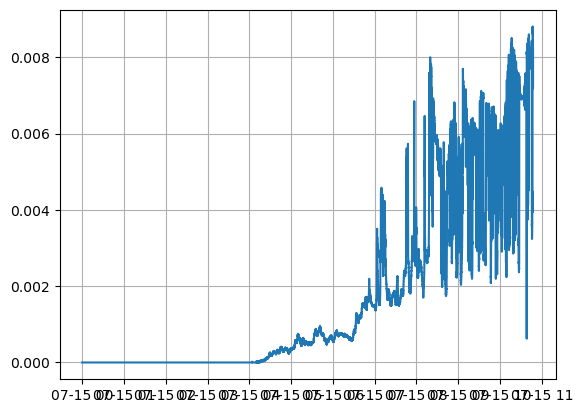

In [71]:
#|hide
# dsp = ds_l1b.sel(time="2019-07-15")
# plt.figure()
# plt.plot(dsp.time, dsp.ghi)
# plt.grid()

4. Drop first and last X minutes of data to avoid bad data due to maintenance

```{note}
config.json -> "stripminutes"
```

In [72]:
#|dropcode
#|dropout
# 4. Drop first and last <stripminutes> minutes of data to avoid bad data due to maintenance

# stripminutes = np.timedelta64(int(config['stripminutes']), 'm')
# for now use some seconds for demonstration
stripminutes = np.timedelta64(2, 's')
tslice = slice(ds_l1b.time.values[0] + stripminutes,
               ds_l1b.time.values[-1] - stripminutes)
ds_l1b = ds_l1b.sel(time=tslice)
ds_l1b

<xarray.Dataset>
Dimensions:          (time: 6097497, station: 1)
Coordinates:
  * station          (station) uint8 38
  * time             (time) datetime64[ns] 2019-07-08T09:25:25.297000 ... 201...
Data variables:
    ghi              (time, station) float32 ...
    gti              (time, station) float32 ...
    ta               (time, station) float32 ...
    rh               (time, station) float32 ...
    battery_voltage  (time, station) float32 ...
Attributes: (12/31)
    title:                     TROPOS pyranometer network (PyrNet) observations
    institution:               Leibniz Institute for Tropospheric Research (T...
    department:                Remote Sensing of Atmospheric Processes
    department_team:           Clouds, Aerosol and Radiation
    address:                   Permoser Str. 15, 04318 Leipzig, Germany
    source:                    TROPOS pyranometer network (PyrNet)
    ...                        ...
    geospatial_lon_max:        10.497641666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2019-07-08T09:25:54.095000
    time_coverage_end:         2019-07-15T10:47:26
    time_coverage_duration:    P7DT1H21M31.905S
    time_coverage_resolution:  P0DT0H0M1.000001484S

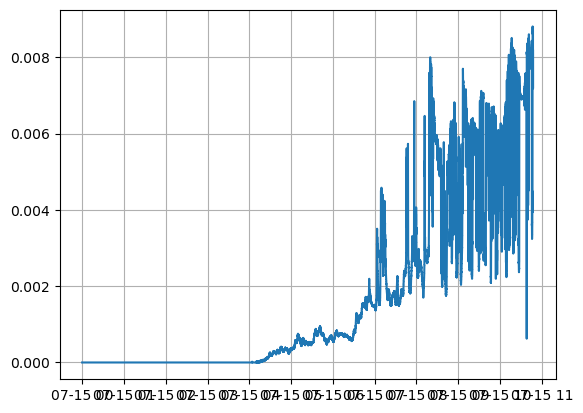

In [73]:
#|hide
# dsp = ds_l1b.sel(time="2019-07-15")
# plt.figure()
# plt.plot(dsp.time, dsp.ghi)
# plt.grid()

5. Apply appropriate binning to ADC values
    * ```pyrnet.logger.resample_mean```


In [74]:
#|dropcode
#|dropout
# 5. resample to desired resolution
ds_l1b = pyrlogger.resample_mean(ds_l1b,freq=config['l1bfreq'])

ds_l1b

<xarray.Dataset>
Dimensions:          (time: 609720, station: 1)
Coordinates:
  * station          (station) uint8 38
  * time             (time) datetime64[ns] 2019-07-08T09:25:25 ... 2019-07-15...
Data variables:
    ghi              (time, station) float64 0.0008038 0.0008097 ... 0.008125
    gti              (time, station) float64 0.0004919 0.0004882 ... 0.006418
    ta               (time, station) float64 287.7 286.6 286.2 ... 291.7 291.7
    rh               (time, station) float64 0.925 0.9248 ... 0.6637 0.6663
    battery_voltage  (time, station) float64 6.416 6.417 6.416 ... 5.068 5.081
Attributes: (12/31)
    title:                     TROPOS pyranometer network (PyrNet) observations
    institution:               Leibniz Institute for Tropospheric Research (T...
    department:                Remote Sensing of Atmospheric Processes
    department_team:           Clouds, Aerosol and Radiation
    address:                   Permoser Str. 15, 04318 Leipzig, Germany
    source:                    TROPOS pyranometer network (PyrNet)
    ...                        ...
    geospatial_lon_max:        10.497641666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2019-07-08T09:25:54.095000
    time_coverage_end:         2019-07-15T10:47:26
    time_coverage_duration:    P7DT1H21M31.905S
    time_coverage_resolution:  P0DT0H0M1.000001484S

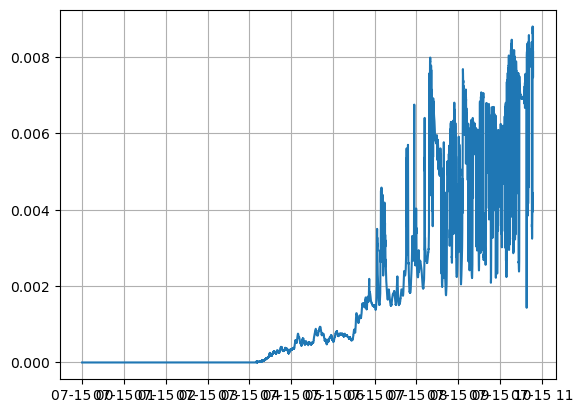

In [75]:
#|hide
# dsp = ds_l1b.sel(time="2019-07-15")
# plt.figure()
# plt.plot(dsp.time, dsp.ghi)
# plt.grid()

 * stretch valid_range to not lose resolution due to averaging

In [76]:
#|dropcode
#|dropout
# stretch valid range to not lose resolution due to averaging
ds_l1b = stretch_resolution(ds_l1b)
ds_l1b

<xarray.Dataset>
Dimensions:          (time: 609720, station: 1)
Coordinates:
  * station          (station) uint8 38
  * time             (time) datetime64[ns] 2019-07-08T09:25:25 ... 2019-07-15...
Data variables:
    ghi              (time, station) float64 0.0008038 0.0008097 ... 0.008125
    gti              (time, station) float64 0.0004919 0.0004882 ... 0.006418
    ta               (time, station) float64 287.7 286.6 286.2 ... 291.7 291.7
    rh               (time, station) float64 0.925 0.9248 ... 0.6637 0.6663
    battery_voltage  (time, station) float64 6.416 6.417 6.416 ... 5.068 5.081
Attributes: (12/31)
    title:                     TROPOS pyranometer network (PyrNet) observations
    institution:               Leibniz Institute for Tropospheric Research (T...
    department:                Remote Sensing of Atmospheric Processes
    department_team:           Clouds, Aerosol and Radiation
    address:                   Permoser Str. 15, 04318 Leipzig, Germany
    source:                    TROPOS pyranometer network (PyrNet)
    ...                        ...
    geospatial_lon_max:        10.497641666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2019-07-08T09:25:54.095000
    time_coverage_end:         2019-07-15T10:47:26
    time_coverage_duration:    P7DT1H21M31.905S
    time_coverage_resolution:  P0DT0H0M1.000001484S

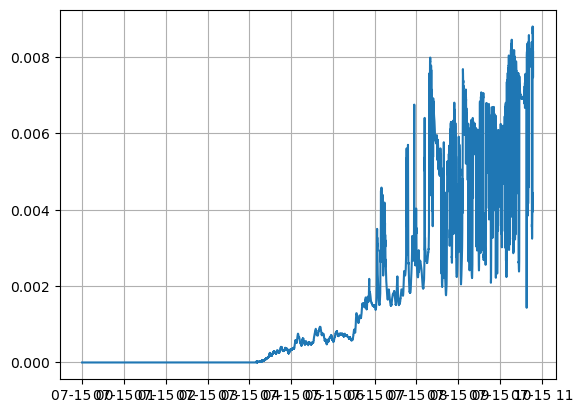

In [77]:
#|hide
# dsp = ds_l1b.sel(time="2019-07-15")
# plt.figure()
# plt.plot(dsp.time, dsp.ghi)
# plt.grid()

6. Interpolate GPS coordinates to bin time
    * ```xarray.interp```
    ```{note}
    At this point the descision to whether store geocoordinates in full time resolution or as mean over the time interval is made.

    This is configured in config.json -> "average_latlon"
    ```

In [78]:
#|dropcode
#|dropout

# 6. Interpolate GPS coordinates to bin time
ds_gps = ds_l1a.drop_dims("adctime")
ds_gps = ds_gps.drop_vars(['iadc'])


# Decide whether geo coordinates should be averaged or not

# if config['average_latlon']:
ds_gps_avg = ds_gps.mean('gpstime',skipna=True)
ds_l1b_avg = xr.merge((ds_l1b,ds_gps_avg))

# else:
ds_gps = ds_gps.interp(gpstime=ds_l1b.time,
                       kwargs={"bounds_error":False, "fill_value":np.nan})
ds_gps = ds_gps.drop_vars("gpstime")

ds_l1b = xr.merge((ds_l1b,ds_gps))

ds_l1b

<xarray.Dataset>
Dimensions:          (time: 609720, station: 1)
Coordinates:
  * station          (station) uint8 38
  * time             (time) datetime64[ns] 2019-07-08T09:25:25 ... 2019-07-15...
Data variables:
    ghi              (time, station) float64 0.0008038 0.0008097 ... 0.008125
    gti              (time, station) float64 0.0004919 0.0004882 ... 0.006418
    ta               (time, station) float64 287.7 286.6 286.2 ... 291.7 291.7
    rh               (time, station) float64 0.925 0.9248 ... 0.6637 0.6663
    battery_voltage  (time, station) float64 6.416 6.417 6.416 ... 5.068 5.081
    lat              (time, station) float64 nan nan nan ... 47.65 47.65 47.65
    lon              (time, station) float64 nan nan nan nan ... 10.5 10.5 10.5
    ghi_qc           (station) float32 5.0
    gti_qc           (station) float32 4.0
Attributes: (12/31)
    title:                     TROPOS pyranometer network (PyrNet) observations
    institution:               Leibniz Institute for Tropospheric Research (T...
    department:                Remote Sensing of Atmospheric Processes
    department_team:           Clouds, Aerosol and Radiation
    address:                   Permoser Str. 15, 04318 Leipzig, Germany
    source:                    TROPOS pyranometer network (PyrNet)
    ...                        ...
    geospatial_lon_max:        10.497641666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2019-07-08T09:25:54.095000
    time_coverage_end:         2019-07-15T10:47:26
    time_coverage_duration:    P7DT1H21M31.905S
    time_coverage_resolution:  P0DT0H0M1.000001484S

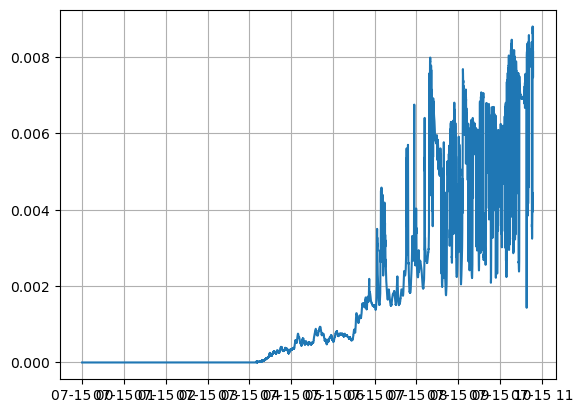

In [79]:
#|hide
# dsp = ds_l1b.sel(time="2019-07-15")
# plt.figure()
# plt.plot(dsp.time, dsp.ghi)
# plt.grid()

7. Calculate sun position
    * ```trosat.sunpos```


In [80]:
#|dropcode
#|dropout
# 7. Calc and add sun position

szen, sazi = sp.sun_angles(
    time=ds_l1b.time.values[:,None],
    lat=ds_l1b.lat.values,
    lon=ds_l1b.lon.values
)


szen_avg, sazi_avg = sp.sun_angles(
    time=ds_l1b_avg.time.values[:,None],
    lat=ds_l1b_avg.lat.values,
    lon=ds_l1b_avg.lon.values
)

szen  = szen.squeeze()
sazi = sazi.squeeze()
szen_avg = szen_avg.squeeze()
sazi_avg = sazi_avg.squeeze()


esd = np.mean(sp.earth_sun_distance(ds_l1b.time.values))

print('szen (avg latlon):', szen_avg)
print('szen:', szen)
print('sazi  (avg latlon):', sazi_avg)
print('sazi:', sazi)
print('Earth-Sun Distance:',esd)

szen (avg latlon): [34.42771023 34.42545909 34.42320812 ... 27.14417921 27.14327102
 27.14236321]
szen: [        nan         nan         nan ... 27.14416311 27.14326132
 27.1423535 ]
sazi  (avg latlon): [126.62762262 126.6331462  126.63867029 ... 161.07721789 161.08547658
 161.09373572]
sazi: [         nan          nan          nan ... 161.07717691 161.08544201
 161.09370116]
Earth-Sun Distance: 1.016876541618894


In [81]:
#|dropcode
#|dropout
ds_l1b = ds_l1b.assign(
    {
        "szen": (("time", "station"), szen[:,None]),
        "sazi": (("time", "station"), sazi[:,None]),
        "esd": ("station", [esd])
    }
)
for key in ['szen', 'sazi','esd']:
    ds_l1b[key].attrs.update(vattrs[key])
    ds_l1b[key].encoding.update(vencode[key])
ds_l1b

<xarray.Dataset>
Dimensions:          (time: 609720, station: 1)
Coordinates:
  * station          (station) uint8 38
  * time             (time) datetime64[ns] 2019-07-08T09:25:25 ... 2019-07-15...
Data variables:
    ghi              (time, station) float64 0.0008038 0.0008097 ... 0.008125
    gti              (time, station) float64 0.0004919 0.0004882 ... 0.006418
    ta               (time, station) float64 287.7 286.6 286.2 ... 291.7 291.7
    rh               (time, station) float64 0.925 0.9248 ... 0.6637 0.6663
    battery_voltage  (time, station) float64 6.416 6.417 6.416 ... 5.068 5.081
    lat              (time, station) float64 nan nan nan ... 47.65 47.65 47.65
    lon              (time, station) float64 nan nan nan nan ... 10.5 10.5 10.5
    ghi_qc           (station) float32 5.0
    gti_qc           (station) float32 4.0
    szen             (time, station) float64 nan nan nan ... 27.14 27.14 27.14
    sazi             (time, station) float64 nan nan nan ... 161.1 161.1 161.1
    esd              (station) float64 1.017
Attributes: (12/31)
    title:                     TROPOS pyranometer network (PyrNet) observations
    institution:               Leibniz Institute for Tropospheric Research (T...
    department:                Remote Sensing of Atmospheric Processes
    department_team:           Clouds, Aerosol and Radiation
    address:                   Permoser Str. 15, 04318 Leipzig, Germany
    source:                    TROPOS pyranometer network (PyrNet)
    ...                        ...
    geospatial_lon_max:        10.497641666666667
    geospatial_lon_units:      degE
    time_coverage_start:       2019-07-08T09:25:54.095000
    time_coverage_end:         2019-07-15T10:47:26
    time_coverage_duration:    P7DT1H21M31.905S
    time_coverage_resolution:  P0DT0H0M1.000001484S

8. Calibrate radiation flux
9. Update variables and global attributes and encoding

In [82]:
#|dropcode
#|dropout
# 8. rad flux calibration
box = ds_l1b.station.values[0]
boxnumber, serial, cfac = pyrnet.meta_lookup(
    ds_l1b.time.values[0],
    box=box,
    cfile=config['file_calibration'],
    mapfile=config['file_mapping'],
)

print(f"Meta Lookup:")
print(f">> Box={box}")
print(f">> serial(s)={serial}")
print(f"calibration factor(s)={cfac}")


# calibrate radiation flux with gain=300
for i, radflx in enumerate(config['radflux_varname']):
    if cfac[i] is None:
        # drop if calibration/instrument don't exist (probably secondary pyranometer).
        ds_l1b = ds_l1b.drop_vars([var for var in ds_l1b if radflx in var])
        continue
    ds_l1b[radflx].values = ds_l1b[radflx].values*1e6/cfac[i] # V -> W m-2
    ds_l1b[radflx].attrs['units'] = "W m-2",
    ds_l1b[radflx].attrs.update({
        "units": "W m-2",
        "serial": serial[i],
        "calibration_factor": cfac[i]
    })
    ds_l1b[radflx].encoding.update({
        'scale_factor': ds_l1b[radflx].encoding['scale_factor']*1e6/cfac[i]
    })


# add global coverage attributes
ds_l1b = update_coverage_meta(ds_l1b, timevar="time")

ds_l1b.attrs["processing_level"] = 'l1b'
now = pd.to_datetime(np.datetime64("now"))
ds_l1b.attrs["history"] = ds_l1b.history + f"{now.isoformat()}: Generated level l1b  by pyrnet version {pyrnet_version}; "

ds_l1b

Meta Lookup:
>> Box=38
>> serial(s)=['S12128.038', 'S12128.039']
calibration factor(s)=[7.62, 6.93]


<xarray.Dataset>
Dimensions:          (time: 609720, station: 1)
Coordinates:
  * station          (station) uint8 38
  * time             (time) datetime64[ns] 2019-07-08T09:25:25 ... 2019-07-15...
Data variables:
    ghi              (time, station) float64 105.5 106.3 ... 1.025e+03 1.066e+03
    gti              (time, station) float64 70.99 70.44 69.98 ... 885.2 926.2
    ta               (time, station) float64 287.7 286.6 286.2 ... 291.7 291.7
    rh               (time, station) float64 0.925 0.9248 ... 0.6637 0.6663
    battery_voltage  (time, station) float64 6.416 6.417 6.416 ... 5.068 5.081
    lat              (time, station) float64 nan nan nan ... 47.65 47.65 47.65
    lon              (time, station) float64 nan nan nan nan ... 10.5 10.5 10.5
    ghi_qc           (station) float32 5.0
    gti_qc           (station) float32 4.0
    szen             (time, station) float64 nan nan nan ... 27.14 27.14 27.14
    sazi             (time, station) float64 nan nan nan ... 161.1 161.1 161.1
    esd              (station) float64 1.017
Attributes: (12/31)
    title:                     TROPOS pyranometer network (PyrNet) observations
    institution:               Leibniz Institute for Tropospheric Research (T...
    department:                Remote Sensing of Atmospheric Processes
    department_team:           Clouds, Aerosol and Radiation
    address:                   Permoser Str. 15, 04318 Leipzig, Germany
    source:                    TROPOS pyranometer network (PyrNet)
    ...                        ...
    geospatial_lon_max:        10.497641999999985
    geospatial_lon_units:      degE
    time_coverage_start:       2019-07-08T09:25:25
    time_coverage_end:         2019-07-15T10:47:24
    time_coverage_duration:    P7DT1H21M59S
    time_coverage_resolution:  P0DT0H0M1S

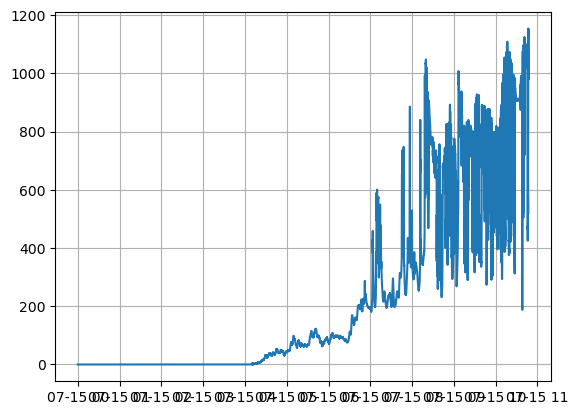

In [83]:
#|hide
# dsp = ds_l1b.sel(time="2019-07-15")
# plt.figure()
# plt.plot(dsp.time, dsp.ghi)
# plt.grid()

In [84]:
#|hide
# ds_l1b.to_netcdf("../../testnb/to_l1b_output.nc",
#                  encoding={'time':{'dtype':'float64'}})

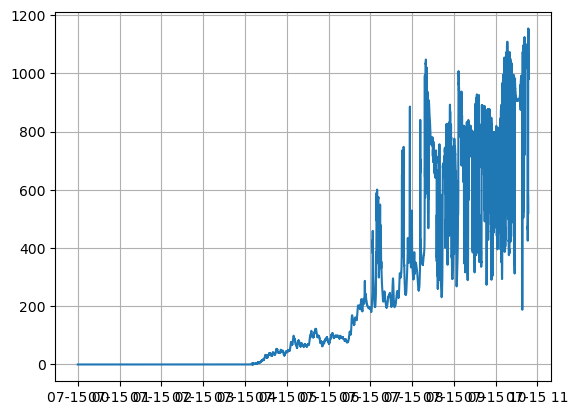

In [85]:
#|hide
# dsp = xr.load_dataset("../../testnb/to_l1b_output.nc").sel(time="2019-07-15")
# plt.figure()
# plt.plot(dsp.time, dsp.ghi)
# plt.grid()

In [ ]:
#|export
#|dropcode
def to_l1b(
        fname: str,
        *,
        config: dict | None = None,
        global_attrs: dict | None = None
) -> xr.Dataset:

    config = get_config(config)
    gattrs, vattrs, vencode = get_cfmeta(config)

    if global_attrs is not None:
        gattrs.update(global_attrs)

    # 1. Load l1a data
    ds_l1a = xr.open_dataset(fname)
    # check correct file
    if ds_l1a.processing_level != "l1a":
        raise ValueError(f"{fname} is not a l1a file.")

    # 2. Sync GPS to ADC time
    adctime = pyrlogger.sync_adc_time(
        adctime = ds_l1a.adctime.values,
        gpstime = ds_l1a.gpstime.values,
        iadc = ds_l1a.iadc.squeeze().values.astype(int)
    )

    # 3. Create new dataset (l1b)
    ds_l1b = ds_l1a.drop_dims('gpstime')
    ds_l1b = ds_l1b.drop_vars(['ghi_qc','gti_qc']) # keep only time dependend variables
    ds_l1b = ds_l1b.assign({'time': ('adctime', adctime)})
    ds_l1b = ds_l1b.swap_dims({"adctime":"time"})
    ds_l1b = ds_l1b.drop_vars("adctime")

    ds_l1b["time"].encoding.update({
        "dtype": 'float64',
        "units": f"seconds since {np.datetime_as_string(ds_l1b.time.data[0], unit='D')}T00:00Z",
    })
    logger.info(f"Dataset time coverage before strip: {ds_l1b.time.values[0]} - {ds_l1b.time.values[-1]}")

    # 4. Drop first and last <stripminutes> minutes of data to avoid bad data due to maintenance
    stripminutes = np.timedelta64(int(config['stripminutes']), 'm')
    ds_l1b = ds_l1b.isel(time=ds_l1b.time>ds_l1b.time.values[0] + stripminutes)
    ds_l1b = ds_l1b.isel(time=ds_l1b.time<ds_l1b.time.values[-1] - stripminutes)
    logger.info(f"Dataset time coverage after strip: {ds_l1b.time.values[0]} - {ds_l1b.time.values[-1]}")


    # 5. resample to desired resolution
    ds_l1b = pyrlogger.resample_mean(ds_l1b, freq=config['l1bfreq'])
    # stretch valid range to not lose resolution due to averaging
    ds_l1b = stretch_resolution(ds_l1b)

    # 6. Interpolate GPS coordinates to l1b time
    ds_gps = ds_l1a.drop_dims("adctime")
    ds_gps = ds_gps.drop_vars(['iadc'])

    # Decide whether geo coordinates should be averaged or not
    if config['average_latlon']:
        ds_gps = ds_gps.mean('gpstime', skipna=True, keep_attrs=True)
    else:
        ds_gps = ds_gps.interp(gpstime=ds_l1b.time)
        ds_gps = ds_gps.drop_vars("gpstime")

    ds_l1b = xr.merge((ds_l1b,ds_gps))

    # 7. Calc and add sun position
    szen, sazi = sp.sun_angles(
        time=ds_l1b.time.values[:,None], # line up with coordinates to keep dependence on time only
        lat=ds_l1b.lat.values,
        lon=ds_l1b.lon.values
    )
    szen  = szen.squeeze()
    sazi = sazi.squeeze()

    esd = np.mean(sp.earth_sun_distance(ds_l1b.time.values))

    ds_l1b = ds_l1b.assign(
        {
            "szen": (("time", "station"), szen[:,None]),
            "sazi": (("time", "station"), sazi[:,None]),
            "esd": ("station", [esd])
        }
    )
    # update attributes and encoding
    for key in ['szen', 'sazi','esd']:
        ds_l1b[key].attrs.update(vattrs[key])
        ds_l1b[key].encoding.update(vencode[key])


    # 8. rad flux calibration
    box = ds_l1b.station.values[0]
    boxnumber, serial, cfac = pyrnet.meta_lookup(
        ds_l1b.time.values[0],
        box=box,
        cfile=config['file_calibration'],
        mapfile=config['file_mapping'],
    )
    logger.info(f"Meta Lookup:")
    logger.info(f">> Box={box}")
    logger.info(f">> serial(s)={serial}")
    logger.info(f">> calibration factor(s)={cfac}")


    # calibrate radiation flux with gain=300
    for i, radflx in enumerate(config['radflux_varname']):
        if cfac[i] is None:
            # drop if calibration/instrument don't exist (probably secondary pyranometer).
            ds_l1b = ds_l1b.drop_vars([var for var in ds_l1b if radflx in var])
            continue
        ds_l1b[radflx].values = ds_l1b[radflx].values*1e6/(cfac[i]) # V -> W m-2
        ds_l1b[radflx].attrs['units'] = "W m-2",
        ds_l1b[radflx].attrs.update({
            "units": "W m-2",
            "serial": serial[i],
            "calibration_factor": cfac[i]
        })
        ds_l1b[radflx].encoding.update({
            'scale_factor': ds_l1b[radflx].encoding['scale_factor']*1e6/(cfac[i])
        })


    # add global coverage attributes
    ds_l1b = update_coverage_meta(ds_l1b, timevar="time")

    ds_l1b.attrs["processing_level"] = 'l1b'
    now = pd.to_datetime(np.datetime64("now"))
    ds_l1b.attrs["history"] = ds_l1b.history + f"{now.isoformat()}: Generated level l1b  by pyrnet version {pyrnet_version}; "

    return ds_l1b

In [ ]:
#|dropout
fname = "../../example_data/to_l1a_output.nc"
config = {
    "l1bfreq":"1s",
    "stripminutes":0,
    "average_latlon":True,
}

ds_l1b = to_l1b(fname=fname, config=config)
ds_l1b.to_netcdf("../../example_data/to_l1b_output.nc",
                 encoding={'time':{'dtype':'float64'}}) # use float64 and not int64 for opendap2 compatibility

In [ ]:
#|dropout
import netCDF4
netCDF4.Dataset("../../example_data/to_l1b_output.nc",'r')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: TROPOS pyranometer network (PyrNet) observations
    institution: Leibniz Institute for Tropospheric Research (TROPOS)
    department: Remote Sensing of Atmospheric Processes
    department_team: Clouds, Aerosol and Radiation
    address: Permoser Str. 15, 04318 Leipzig, Germany
    source: TROPOS pyranometer network (PyrNet)
    contact_person: Andreas Macke and the clouds, aerosol and radiation team of the remote sensing department, mailto:andreas.macke@tropos.de
    contributor_name: 
    contributor_role: 
    authors_software: Hartwig Deneke, Jonas Witthuhn, mailto:deneke@tropos.de
    creator_name: 
    project: 
    references: https://doi.org/10.5194/amt-9-1153-2016
    standard_name_vocabulary: CF Standard Name Table v81
    conventions: CF-1.10, ACDD-1.3
    license: CC-BY-SA 3.0
    TESTNOTE: This is a test note.
    processing_level: l1b
    product_version: 0.1.5+0.g2e12ffe.dir

In [ ]:
#|hide
# Export module
# Requires *nbdev* to export and update the *../lib/logger.py* module
import nbdev.export
import nbformat as nbf
name = "data"

# Export python module
nbdev.export.nb_export( f"{name}.ipynb" ,f"../../src/pyrnet")

# Export to docs
ntbk = nbf.read(f"{name}.ipynb", nbf.NO_CONVERT)

text_search_dict = {
    "#|hide": "remove-cell",  # Remove the whole cell
    "#|dropcode": "hide-input",  # Hide the input w/ a button to show
    "#|dropout": "hide-output"  # Hide the output w/ a button to show
}
for cell in ntbk.cells:
    cell_tags = cell.get('metadata', {}).get('tags', [])
    for key, val in text_search_dict.items():
            if key in cell['source']:
                if val not in cell_tags:
                    cell_tags.append(val)
    if len(cell_tags) > 0:
        cell['metadata']['tags'] = cell_tags
    nbf.write(ntbk, f"../../docs/source/nbs/{name}.ipynb")